# Deep Residual Learning for Image Recognition on CIFAR-10

**Author:** Omanshi Kaushal

This notebook implements and compares a plain deep CNN with a ResNet model on the CIFAR-10 image classification task.  
The goal is to observe the effects of residual connections on training dynamics, accuracy, and generalization.

We will:
- Load and preprocess CIFAR-10 data
- Implement two models: Plain CNN and ResNet
- Train both models under similar conditions
- Plot and compare training/test accuracy and loss curves
- Discuss observations and the importance of residual connections


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm


### Data Loading and Preprocessing

We use the CIFAR-10 dataset, consisting of 60,000 32x32 color images in 10 classes.  
Data augmentation includes random cropping and horizontal flipping for robust training.


In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465), (0.247,0.243,0.261))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465), (0.247,0.243,0.261))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:03<00:00, 48.3MB/s]


### Plain CNN Model

A basic convolutional neural network with increasing feature maps, batch normalization, and ReLU activations. No skip connections.


In [3]:
class PlainCNN(nn.Module):
    def __init__(self):
        super(PlainCNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # Downsample

            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        out = self.layers(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


### ResNet Model

A simplified ResNet-20 style architecture composed of residual blocks, designed to ease training of very deep networks.


In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.downsample(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)


In [5]:
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 16, 3, 1, 1)
        self.bn = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 16, 3)
        self.layer2 = self._make_layer(16, 32, 3, stride=2)
        self.layer3 = self._make_layer(32, 64, 3, stride=2)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(64, 10)

    def _make_layer(self, in_ch, out_ch, blocks, stride=1):
        layers = []
        layers.append(ResidualBlock(in_ch, out_ch, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_ch, out_ch))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.bn(self.conv(x))
        out = F.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [6]:
def train_one_epoch(model, device, trainloader, optimizer, criterion):
    model.train()
    running_loss = 0.
    correct = 0
    total = 0
    for inputs, targets in tqdm(trainloader, desc='Training', leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)
    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc

def evaluate(model, device, testloader, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.
    with torch.no_grad():
        for inputs, targets in tqdm(testloader, desc='Testing', leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)
    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc


### Training Procedure

We train both the PlainCNN and ResNet models for 100 epochs each.
Training and validation loss and accuracy per epoch are recorded for comparison.


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Data preparation with augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465), (0.247,0.243,0.261))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465), (0.247,0.243,0.261))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Plain CNN model
class PlainCNN(nn.Module):
    def __init__(self):
        super(PlainCNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(),
            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        self.fc = nn.Linear(64, 10)

    def forward(self,x):
        out = self.layers(x)
        out = out.view(out.size(0), -1)
        return self.fc(out)

# Residual Block and ResNet model
class ResidualBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels,3,stride,1,bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels,out_channels,3,1,1,bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride!=1 or in_channels!=out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,1,stride,bias=False),
                nn.BatchNorm2d(out_channels))
    def forward(self,x):
        identity = self.downsample(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)

class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3,16,3,1,1)
        self.bn = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16,16,3)
        self.layer2 = self._make_layer(16,32,3,stride=2)
        self.layer3 = self._make_layer(32,64,3,stride=2)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(64,10)
    def _make_layer(self,in_ch,out_ch,blocks,stride=1):
        layers = []
        layers.append(ResidualBlock(in_ch,out_ch,stride))
        for _ in range(1,blocks):
            layers.append(ResidualBlock(out_ch,out_ch))
        return nn.Sequential(*layers)
    def forward(self,x):
        out = self.bn(self.conv(x))
        out = F.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.pool(out)
        out = out.view(out.size(0),-1)
        out = self.fc(out)
        return out

# Training and evaluation functions
def train_one_epoch(model, device, trainloader, optimizer, criterion):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for inputs, targets in tqdm(trainloader, leave=False):
        inputs,targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*inputs.size(0)
        _,predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)
    return running_loss/total, correct/total

def evaluate(model, device, testloader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in tqdm(testloader, leave=False):
            inputs,targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item()*inputs.size(0)
            _,predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)
    return running_loss/total, correct/total

# Run training for 100 epochs for both models
def run_training(model_class, model_name, device, trainloader, testloader, epochs=100):
    model = model_class().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,75], gamma=0.1)
    criterion = nn.CrossEntropyLoss()

    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    for epoch in range(epochs):
        train_loss, train_acc = train_one_epoch(model, device, trainloader, optimizer, criterion)
        test_loss, test_acc = evaluate(model, device, testloader, criterion)
        scheduler.step()
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        print(f'{model_name} Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

    return train_losses, train_accs, test_losses, test_accs

# Train PlainCNN for 100 epochs
train_losses_plain, train_accs_plain, test_losses_plain, test_accs_plain = run_training(
    PlainCNN, 'PlainCNN', device, trainloader, testloader, epochs=100
)

# Train ResNet for 100 epochs
train_losses_resnet, train_accs_resnet, test_losses_resnet, test_accs_resnet = run_training(
    ResNet, 'ResNet', device, trainloader, testloader, epochs=100
)


Using device: cuda


PlainCNN Epoch 1/100 - Train Loss: 1.4652, Train Acc: 0.4558 - Test Loss: 1.7321, Test Acc: 0.4401


PlainCNN Epoch 2/100 - Train Loss: 1.0277, Train Acc: 0.6303 - Test Loss: 1.3359, Test Acc: 0.5656


PlainCNN Epoch 3/100 - Train Loss: 0.8732, Train Acc: 0.6920 - Test Loss: 0.8732, Test Acc: 0.6947


PlainCNN Epoch 4/100 - Train Loss: 0.7694, Train Acc: 0.7325 - Test Loss: 0.9576, Test Acc: 0.6814


PlainCNN Epoch 5/100 - Train Loss: 0.7115, Train Acc: 0.7538 - Test Loss: 1.0836, Test Acc: 0.6530


PlainCNN Epoch 6/100 - Train Loss: 0.6621, Train Acc: 0.7683 - Test Loss: 1.0540, Test Acc: 0.6785


PlainCNN Epoch 7/100 - Train Loss: 0.6300, Train Acc: 0.7823 - Test Loss: 0.6820, Test Acc: 0.7635


PlainCNN Epoch 8/100 - Train Loss: 0.6005, Train Acc: 0.7913 - Test Loss: 0.9677, Test Acc: 0.7060


PlainCNN Epoch 9/100 - Train Loss: 0.5801, Train Acc: 0.7986 - Test Loss: 0.7320, Test Acc: 0.7565


PlainCNN Epoch 10/100 - Train Loss: 0.5613, Train Acc: 0.8050 - Test Loss: 0.7256, Test Acc: 0.7571


PlainCNN Epoch 11/100 - Train Loss: 0.5446, Train Acc: 0.8113 - Test Loss: 0.6623, Test Acc: 0.7741


PlainCNN Epoch 12/100 - Train Loss: 0.5290, Train Acc: 0.8178 - Test Loss: 0.6288, Test Acc: 0.7899


PlainCNN Epoch 13/100 - Train Loss: 0.5165, Train Acc: 0.8227 - Test Loss: 0.7177, Test Acc: 0.7682


PlainCNN Epoch 14/100 - Train Loss: 0.5095, Train Acc: 0.8230 - Test Loss: 0.5882, Test Acc: 0.7982


PlainCNN Epoch 15/100 - Train Loss: 0.4930, Train Acc: 0.8311 - Test Loss: 0.7127, Test Acc: 0.7658


PlainCNN Epoch 16/100 - Train Loss: 0.4898, Train Acc: 0.8305 - Test Loss: 0.6012, Test Acc: 0.7988


PlainCNN Epoch 17/100 - Train Loss: 0.4810, Train Acc: 0.8344 - Test Loss: 0.6373, Test Acc: 0.7833


PlainCNN Epoch 18/100 - Train Loss: 0.4730, Train Acc: 0.8369 - Test Loss: 0.6702, Test Acc: 0.7835


PlainCNN Epoch 19/100 - Train Loss: 0.4703, Train Acc: 0.8377 - Test Loss: 0.5296, Test Acc: 0.8210


PlainCNN Epoch 20/100 - Train Loss: 0.4651, Train Acc: 0.8398 - Test Loss: 0.6274, Test Acc: 0.7931


PlainCNN Epoch 21/100 - Train Loss: 0.4566, Train Acc: 0.8424 - Test Loss: 0.6511, Test Acc: 0.7911


PlainCNN Epoch 22/100 - Train Loss: 0.4531, Train Acc: 0.8432 - Test Loss: 0.6736, Test Acc: 0.7779


PlainCNN Epoch 23/100 - Train Loss: 0.4471, Train Acc: 0.8446 - Test Loss: 0.6620, Test Acc: 0.7866


PlainCNN Epoch 24/100 - Train Loss: 0.4424, Train Acc: 0.8474 - Test Loss: 0.6459, Test Acc: 0.8014


PlainCNN Epoch 25/100 - Train Loss: 0.4380, Train Acc: 0.8494 - Test Loss: 0.5576, Test Acc: 0.8138


PlainCNN Epoch 26/100 - Train Loss: 0.4336, Train Acc: 0.8489 - Test Loss: 0.6797, Test Acc: 0.7713


PlainCNN Epoch 27/100 - Train Loss: 0.4281, Train Acc: 0.8506 - Test Loss: 0.7255, Test Acc: 0.7653


PlainCNN Epoch 28/100 - Train Loss: 0.4207, Train Acc: 0.8551 - Test Loss: 0.6245, Test Acc: 0.7934


PlainCNN Epoch 29/100 - Train Loss: 0.4237, Train Acc: 0.8529 - Test Loss: 0.6345, Test Acc: 0.7996


PlainCNN Epoch 30/100 - Train Loss: 0.4183, Train Acc: 0.8554 - Test Loss: 0.6249, Test Acc: 0.7882


PlainCNN Epoch 31/100 - Train Loss: 0.4225, Train Acc: 0.8548 - Test Loss: 0.6464, Test Acc: 0.7921


PlainCNN Epoch 32/100 - Train Loss: 0.4142, Train Acc: 0.8571 - Test Loss: 0.5674, Test Acc: 0.8085


PlainCNN Epoch 33/100 - Train Loss: 0.4143, Train Acc: 0.8563 - Test Loss: 0.7469, Test Acc: 0.7774


PlainCNN Epoch 34/100 - Train Loss: 0.4103, Train Acc: 0.8577 - Test Loss: 0.5438, Test Acc: 0.8188


PlainCNN Epoch 35/100 - Train Loss: 0.4096, Train Acc: 0.8587 - Test Loss: 0.6873, Test Acc: 0.7740


PlainCNN Epoch 36/100 - Train Loss: 0.4013, Train Acc: 0.8615 - Test Loss: 0.6190, Test Acc: 0.8051


PlainCNN Epoch 37/100 - Train Loss: 0.4030, Train Acc: 0.8619 - Test Loss: 0.4970, Test Acc: 0.8349


PlainCNN Epoch 38/100 - Train Loss: 0.3999, Train Acc: 0.8626 - Test Loss: 0.6225, Test Acc: 0.8014


PlainCNN Epoch 39/100 - Train Loss: 0.4041, Train Acc: 0.8608 - Test Loss: 0.5192, Test Acc: 0.8304


PlainCNN Epoch 40/100 - Train Loss: 0.3916, Train Acc: 0.8641 - Test Loss: 0.5566, Test Acc: 0.8206


PlainCNN Epoch 41/100 - Train Loss: 0.3929, Train Acc: 0.8630 - Test Loss: 0.5384, Test Acc: 0.8252


PlainCNN Epoch 42/100 - Train Loss: 0.3935, Train Acc: 0.8636 - Test Loss: 0.7392, Test Acc: 0.7719


PlainCNN Epoch 43/100 - Train Loss: 0.3918, Train Acc: 0.8640 - Test Loss: 0.5441, Test Acc: 0.8216


PlainCNN Epoch 44/100 - Train Loss: 0.3895, Train Acc: 0.8646 - Test Loss: 0.5391, Test Acc: 0.8244


PlainCNN Epoch 45/100 - Train Loss: 0.3856, Train Acc: 0.8666 - Test Loss: 0.6321, Test Acc: 0.8065


PlainCNN Epoch 46/100 - Train Loss: 0.3850, Train Acc: 0.8670 - Test Loss: 0.5791, Test Acc: 0.8158


PlainCNN Epoch 47/100 - Train Loss: 0.3846, Train Acc: 0.8657 - Test Loss: 0.6270, Test Acc: 0.7971


PlainCNN Epoch 48/100 - Train Loss: 0.3847, Train Acc: 0.8671 - Test Loss: 0.4698, Test Acc: 0.8453


PlainCNN Epoch 49/100 - Train Loss: 0.3866, Train Acc: 0.8660 - Test Loss: 0.5275, Test Acc: 0.8221


PlainCNN Epoch 50/100 - Train Loss: 0.3824, Train Acc: 0.8662 - Test Loss: 0.5736, Test Acc: 0.8117


PlainCNN Epoch 51/100 - Train Loss: 0.3029, Train Acc: 0.8972 - Test Loss: 0.3913, Test Acc: 0.8667


PlainCNN Epoch 52/100 - Train Loss: 0.2854, Train Acc: 0.9036 - Test Loss: 0.3859, Test Acc: 0.8710


PlainCNN Epoch 53/100 - Train Loss: 0.2779, Train Acc: 0.9065 - Test Loss: 0.3818, Test Acc: 0.8723


PlainCNN Epoch 54/100 - Train Loss: 0.2728, Train Acc: 0.9067 - Test Loss: 0.3830, Test Acc: 0.8705


PlainCNN Epoch 55/100 - Train Loss: 0.2686, Train Acc: 0.9093 - Test Loss: 0.3875, Test Acc: 0.8724


PlainCNN Epoch 56/100 - Train Loss: 0.2662, Train Acc: 0.9103 - Test Loss: 0.3853, Test Acc: 0.8706


PlainCNN Epoch 57/100 - Train Loss: 0.2636, Train Acc: 0.9112 - Test Loss: 0.3923, Test Acc: 0.8711


PlainCNN Epoch 58/100 - Train Loss: 0.2603, Train Acc: 0.9116 - Test Loss: 0.3855, Test Acc: 0.8719


PlainCNN Epoch 59/100 - Train Loss: 0.2560, Train Acc: 0.9132 - Test Loss: 0.3888, Test Acc: 0.8704


PlainCNN Epoch 60/100 - Train Loss: 0.2599, Train Acc: 0.9120 - Test Loss: 0.3845, Test Acc: 0.8720


PlainCNN Epoch 61/100 - Train Loss: 0.2560, Train Acc: 0.9130 - Test Loss: 0.3904, Test Acc: 0.8692


PlainCNN Epoch 62/100 - Train Loss: 0.2541, Train Acc: 0.9125 - Test Loss: 0.3824, Test Acc: 0.8730


PlainCNN Epoch 63/100 - Train Loss: 0.2526, Train Acc: 0.9143 - Test Loss: 0.3892, Test Acc: 0.8746


PlainCNN Epoch 64/100 - Train Loss: 0.2521, Train Acc: 0.9139 - Test Loss: 0.3851, Test Acc: 0.8726


PlainCNN Epoch 65/100 - Train Loss: 0.2505, Train Acc: 0.9147 - Test Loss: 0.3875, Test Acc: 0.8725


PlainCNN Epoch 66/100 - Train Loss: 0.2494, Train Acc: 0.9152 - Test Loss: 0.3988, Test Acc: 0.8689


PlainCNN Epoch 67/100 - Train Loss: 0.2522, Train Acc: 0.9137 - Test Loss: 0.4012, Test Acc: 0.8654


PlainCNN Epoch 68/100 - Train Loss: 0.2480, Train Acc: 0.9160 - Test Loss: 0.3957, Test Acc: 0.8712


PlainCNN Epoch 69/100 - Train Loss: 0.2465, Train Acc: 0.9155 - Test Loss: 0.3936, Test Acc: 0.8679


PlainCNN Epoch 70/100 - Train Loss: 0.2432, Train Acc: 0.9164 - Test Loss: 0.3919, Test Acc: 0.8694


PlainCNN Epoch 71/100 - Train Loss: 0.2474, Train Acc: 0.9160 - Test Loss: 0.3965, Test Acc: 0.8672


PlainCNN Epoch 72/100 - Train Loss: 0.2419, Train Acc: 0.9190 - Test Loss: 0.3946, Test Acc: 0.8709


PlainCNN Epoch 73/100 - Train Loss: 0.2463, Train Acc: 0.9161 - Test Loss: 0.3872, Test Acc: 0.8733


PlainCNN Epoch 74/100 - Train Loss: 0.2426, Train Acc: 0.9181 - Test Loss: 0.3867, Test Acc: 0.8715


PlainCNN Epoch 75/100 - Train Loss: 0.2438, Train Acc: 0.9168 - Test Loss: 0.3983, Test Acc: 0.8687


PlainCNN Epoch 76/100 - Train Loss: 0.2336, Train Acc: 0.9207 - Test Loss: 0.3792, Test Acc: 0.8728


PlainCNN Epoch 77/100 - Train Loss: 0.2294, Train Acc: 0.9223 - Test Loss: 0.3788, Test Acc: 0.8735


PlainCNN Epoch 78/100 - Train Loss: 0.2244, Train Acc: 0.9244 - Test Loss: 0.3789, Test Acc: 0.8752


PlainCNN Epoch 79/100 - Train Loss: 0.2286, Train Acc: 0.9237 - Test Loss: 0.3807, Test Acc: 0.8730


PlainCNN Epoch 80/100 - Train Loss: 0.2234, Train Acc: 0.9249 - Test Loss: 0.3778, Test Acc: 0.8746


PlainCNN Epoch 81/100 - Train Loss: 0.2268, Train Acc: 0.9235 - Test Loss: 0.3778, Test Acc: 0.8733


PlainCNN Epoch 82/100 - Train Loss: 0.2253, Train Acc: 0.9224 - Test Loss: 0.3810, Test Acc: 0.8750


PlainCNN Epoch 83/100 - Train Loss: 0.2249, Train Acc: 0.9236 - Test Loss: 0.3800, Test Acc: 0.8741


PlainCNN Epoch 84/100 - Train Loss: 0.2238, Train Acc: 0.9255 - Test Loss: 0.3812, Test Acc: 0.8731


PlainCNN Epoch 85/100 - Train Loss: 0.2252, Train Acc: 0.9241 - Test Loss: 0.3825, Test Acc: 0.8741


PlainCNN Epoch 86/100 - Train Loss: 0.2245, Train Acc: 0.9231 - Test Loss: 0.3797, Test Acc: 0.8734


PlainCNN Epoch 87/100 - Train Loss: 0.2254, Train Acc: 0.9233 - Test Loss: 0.3821, Test Acc: 0.8723


PlainCNN Epoch 88/100 - Train Loss: 0.2251, Train Acc: 0.9231 - Test Loss: 0.3799, Test Acc: 0.8744


PlainCNN Epoch 89/100 - Train Loss: 0.2259, Train Acc: 0.9224 - Test Loss: 0.3812, Test Acc: 0.8741


PlainCNN Epoch 90/100 - Train Loss: 0.2242, Train Acc: 0.9238 - Test Loss: 0.3791, Test Acc: 0.8733


PlainCNN Epoch 91/100 - Train Loss: 0.2221, Train Acc: 0.9241 - Test Loss: 0.3801, Test Acc: 0.8737


PlainCNN Epoch 92/100 - Train Loss: 0.2232, Train Acc: 0.9247 - Test Loss: 0.3826, Test Acc: 0.8742


PlainCNN Epoch 93/100 - Train Loss: 0.2220, Train Acc: 0.9242 - Test Loss: 0.3796, Test Acc: 0.8743


PlainCNN Epoch 94/100 - Train Loss: 0.2247, Train Acc: 0.9234 - Test Loss: 0.3807, Test Acc: 0.8742


PlainCNN Epoch 95/100 - Train Loss: 0.2243, Train Acc: 0.9234 - Test Loss: 0.3809, Test Acc: 0.8745


PlainCNN Epoch 96/100 - Train Loss: 0.2220, Train Acc: 0.9253 - Test Loss: 0.3792, Test Acc: 0.8740


PlainCNN Epoch 97/100 - Train Loss: 0.2230, Train Acc: 0.9241 - Test Loss: 0.3813, Test Acc: 0.8742


PlainCNN Epoch 98/100 - Train Loss: 0.2232, Train Acc: 0.9239 - Test Loss: 0.3802, Test Acc: 0.8754


PlainCNN Epoch 99/100 - Train Loss: 0.2224, Train Acc: 0.9248 - Test Loss: 0.3800, Test Acc: 0.8748


PlainCNN Epoch 100/100 - Train Loss: 0.2204, Train Acc: 0.9263 - Test Loss: 0.3818, Test Acc: 0.8738


ResNet Epoch 1/100 - Train Loss: 1.7204, Train Acc: 0.3483 - Test Loss: 1.4614, Test Acc: 0.4695


ResNet Epoch 2/100 - Train Loss: 1.2680, Train Acc: 0.5392 - Test Loss: 1.4638, Test Acc: 0.4941


ResNet Epoch 3/100 - Train Loss: 1.0196, Train Acc: 0.6370 - Test Loss: 1.2270, Test Acc: 0.5843


ResNet Epoch 4/100 - Train Loss: 0.8484, Train Acc: 0.7008 - Test Loss: 0.9706, Test Acc: 0.6651


ResNet Epoch 5/100 - Train Loss: 0.7308, Train Acc: 0.7460 - Test Loss: 0.8012, Test Acc: 0.7309


ResNet Epoch 6/100 - Train Loss: 0.6524, Train Acc: 0.7731 - Test Loss: 0.7322, Test Acc: 0.7487


ResNet Epoch 7/100 - Train Loss: 0.5979, Train Acc: 0.7942 - Test Loss: 0.6254, Test Acc: 0.7861


ResNet Epoch 8/100 - Train Loss: 0.5564, Train Acc: 0.8062 - Test Loss: 0.5667, Test Acc: 0.8009


ResNet Epoch 9/100 - Train Loss: 0.5183, Train Acc: 0.8210 - Test Loss: 0.6662, Test Acc: 0.7728


ResNet Epoch 10/100 - Train Loss: 0.4947, Train Acc: 0.8276 - Test Loss: 0.5685, Test Acc: 0.8154


ResNet Epoch 11/100 - Train Loss: 0.4755, Train Acc: 0.8355 - Test Loss: 0.5173, Test Acc: 0.8236


ResNet Epoch 12/100 - Train Loss: 0.4516, Train Acc: 0.8430 - Test Loss: 0.5389, Test Acc: 0.8198


ResNet Epoch 13/100 - Train Loss: 0.4410, Train Acc: 0.8474 - Test Loss: 0.5549, Test Acc: 0.8158


ResNet Epoch 14/100 - Train Loss: 0.4250, Train Acc: 0.8526 - Test Loss: 0.5905, Test Acc: 0.8059


ResNet Epoch 15/100 - Train Loss: 0.4102, Train Acc: 0.8594 - Test Loss: 0.5897, Test Acc: 0.8098


ResNet Epoch 16/100 - Train Loss: 0.3983, Train Acc: 0.8631 - Test Loss: 0.5431, Test Acc: 0.8309


ResNet Epoch 17/100 - Train Loss: 0.3925, Train Acc: 0.8643 - Test Loss: 0.5854, Test Acc: 0.8161


ResNet Epoch 18/100 - Train Loss: 0.3776, Train Acc: 0.8685 - Test Loss: 0.5446, Test Acc: 0.8305


ResNet Epoch 19/100 - Train Loss: 0.3739, Train Acc: 0.8714 - Test Loss: 0.4630, Test Acc: 0.8481


ResNet Epoch 20/100 - Train Loss: 0.3641, Train Acc: 0.8741 - Test Loss: 0.6058, Test Acc: 0.8123


ResNet Epoch 21/100 - Train Loss: 0.3594, Train Acc: 0.8759 - Test Loss: 0.4614, Test Acc: 0.8482


ResNet Epoch 22/100 - Train Loss: 0.3488, Train Acc: 0.8793 - Test Loss: 0.5065, Test Acc: 0.8323


ResNet Epoch 23/100 - Train Loss: 0.3385, Train Acc: 0.8822 - Test Loss: 0.5208, Test Acc: 0.8345


ResNet Epoch 24/100 - Train Loss: 0.3401, Train Acc: 0.8823 - Test Loss: 0.5754, Test Acc: 0.8208


ResNet Epoch 25/100 - Train Loss: 0.3316, Train Acc: 0.8860 - Test Loss: 0.4679, Test Acc: 0.8444


ResNet Epoch 26/100 - Train Loss: 0.3228, Train Acc: 0.8871 - Test Loss: 0.5144, Test Acc: 0.8360


ResNet Epoch 27/100 - Train Loss: 0.3192, Train Acc: 0.8879 - Test Loss: 0.4526, Test Acc: 0.8522


ResNet Epoch 28/100 - Train Loss: 0.3145, Train Acc: 0.8919 - Test Loss: 0.4568, Test Acc: 0.8509


ResNet Epoch 29/100 - Train Loss: 0.3101, Train Acc: 0.8917 - Test Loss: 0.4620, Test Acc: 0.8488


ResNet Epoch 30/100 - Train Loss: 0.3085, Train Acc: 0.8925 - Test Loss: 0.4853, Test Acc: 0.8467


ResNet Epoch 31/100 - Train Loss: 0.3072, Train Acc: 0.8928 - Test Loss: 0.4566, Test Acc: 0.8523


ResNet Epoch 32/100 - Train Loss: 0.2979, Train Acc: 0.8961 - Test Loss: 0.6171, Test Acc: 0.8130


ResNet Epoch 33/100 - Train Loss: 0.2946, Train Acc: 0.8967 - Test Loss: 0.4351, Test Acc: 0.8612


ResNet Epoch 34/100 - Train Loss: 0.2941, Train Acc: 0.8965 - Test Loss: 0.4379, Test Acc: 0.8523


ResNet Epoch 35/100 - Train Loss: 0.2888, Train Acc: 0.8994 - Test Loss: 0.4767, Test Acc: 0.8488


ResNet Epoch 36/100 - Train Loss: 0.2885, Train Acc: 0.8997 - Test Loss: 0.4678, Test Acc: 0.8505


ResNet Epoch 37/100 - Train Loss: 0.2855, Train Acc: 0.8996 - Test Loss: 0.5089, Test Acc: 0.8445


ResNet Epoch 38/100 - Train Loss: 0.2801, Train Acc: 0.9022 - Test Loss: 0.4086, Test Acc: 0.8655


ResNet Epoch 39/100 - Train Loss: 0.2828, Train Acc: 0.9001 - Test Loss: 0.4494, Test Acc: 0.8531


ResNet Epoch 40/100 - Train Loss: 0.2721, Train Acc: 0.9057 - Test Loss: 0.4483, Test Acc: 0.8569


ResNet Epoch 41/100 - Train Loss: 0.2731, Train Acc: 0.9035 - Test Loss: 0.4830, Test Acc: 0.8440


ResNet Epoch 42/100 - Train Loss: 0.2705, Train Acc: 0.9066 - Test Loss: 0.5354, Test Acc: 0.8362


ResNet Epoch 43/100 - Train Loss: 0.2709, Train Acc: 0.9057 - Test Loss: 0.5641, Test Acc: 0.8281


ResNet Epoch 44/100 - Train Loss: 0.2677, Train Acc: 0.9062 - Test Loss: 0.5064, Test Acc: 0.8427


ResNet Epoch 45/100 - Train Loss: 0.2653, Train Acc: 0.9073 - Test Loss: 0.4684, Test Acc: 0.8511


ResNet Epoch 46/100 - Train Loss: 0.2650, Train Acc: 0.9067 - Test Loss: 0.4117, Test Acc: 0.8721


ResNet Epoch 47/100 - Train Loss: 0.2574, Train Acc: 0.9097 - Test Loss: 0.4315, Test Acc: 0.8595


ResNet Epoch 48/100 - Train Loss: 0.2655, Train Acc: 0.9072 - Test Loss: 0.4018, Test Acc: 0.8729


ResNet Epoch 49/100 - Train Loss: 0.2582, Train Acc: 0.9101 - Test Loss: 0.5136, Test Acc: 0.8414


ResNet Epoch 50/100 - Train Loss: 0.2560, Train Acc: 0.9099 - Test Loss: 0.5799, Test Acc: 0.8220


ResNet Epoch 51/100 - Train Loss: 0.1718, Train Acc: 0.9409 - Test Loss: 0.3057, Test Acc: 0.9021


ResNet Epoch 52/100 - Train Loss: 0.1424, Train Acc: 0.9517 - Test Loss: 0.2991, Test Acc: 0.9030


ResNet Epoch 53/100 - Train Loss: 0.1305, Train Acc: 0.9566 - Test Loss: 0.3023, Test Acc: 0.9045


ResNet Epoch 54/100 - Train Loss: 0.1216, Train Acc: 0.9579 - Test Loss: 0.3079, Test Acc: 0.9040


ResNet Epoch 55/100 - Train Loss: 0.1151, Train Acc: 0.9606 - Test Loss: 0.3087, Test Acc: 0.9057


ResNet Epoch 56/100 - Train Loss: 0.1114, Train Acc: 0.9623 - Test Loss: 0.3110, Test Acc: 0.9043


ResNet Epoch 57/100 - Train Loss: 0.1089, Train Acc: 0.9629 - Test Loss: 0.3154, Test Acc: 0.9035


ResNet Epoch 58/100 - Train Loss: 0.1015, Train Acc: 0.9657 - Test Loss: 0.3161, Test Acc: 0.9044


ResNet Epoch 59/100 - Train Loss: 0.0994, Train Acc: 0.9659 - Test Loss: 0.3157, Test Acc: 0.9048


ResNet Epoch 60/100 - Train Loss: 0.0959, Train Acc: 0.9670 - Test Loss: 0.3230, Test Acc: 0.9060


ResNet Epoch 61/100 - Train Loss: 0.0917, Train Acc: 0.9681 - Test Loss: 0.3279, Test Acc: 0.9054


ResNet Epoch 62/100 - Train Loss: 0.0901, Train Acc: 0.9698 - Test Loss: 0.3290, Test Acc: 0.9043


ResNet Epoch 63/100 - Train Loss: 0.0890, Train Acc: 0.9697 - Test Loss: 0.3337, Test Acc: 0.9036


ResNet Epoch 64/100 - Train Loss: 0.0863, Train Acc: 0.9698 - Test Loss: 0.3366, Test Acc: 0.9043


ResNet Epoch 65/100 - Train Loss: 0.0816, Train Acc: 0.9723 - Test Loss: 0.3345, Test Acc: 0.9061


ResNet Epoch 66/100 - Train Loss: 0.0819, Train Acc: 0.9714 - Test Loss: 0.3373, Test Acc: 0.9052


ResNet Epoch 67/100 - Train Loss: 0.0817, Train Acc: 0.9718 - Test Loss: 0.3438, Test Acc: 0.9048


ResNet Epoch 68/100 - Train Loss: 0.0790, Train Acc: 0.9726 - Test Loss: 0.3458, Test Acc: 0.9039


ResNet Epoch 69/100 - Train Loss: 0.0767, Train Acc: 0.9737 - Test Loss: 0.3547, Test Acc: 0.9027


ResNet Epoch 70/100 - Train Loss: 0.0757, Train Acc: 0.9731 - Test Loss: 0.3538, Test Acc: 0.9040


ResNet Epoch 71/100 - Train Loss: 0.0747, Train Acc: 0.9743 - Test Loss: 0.3480, Test Acc: 0.9059


ResNet Epoch 72/100 - Train Loss: 0.0717, Train Acc: 0.9752 - Test Loss: 0.3474, Test Acc: 0.9057


ResNet Epoch 73/100 - Train Loss: 0.0708, Train Acc: 0.9756 - Test Loss: 0.3585, Test Acc: 0.9059


ResNet Epoch 74/100 - Train Loss: 0.0724, Train Acc: 0.9746 - Test Loss: 0.3595, Test Acc: 0.9050


ResNet Epoch 75/100 - Train Loss: 0.0689, Train Acc: 0.9760 - Test Loss: 0.3662, Test Acc: 0.9027


ResNet Epoch 76/100 - Train Loss: 0.0593, Train Acc: 0.9797 - Test Loss: 0.3571, Test Acc: 0.9042


ResNet Epoch 77/100 - Train Loss: 0.0579, Train Acc: 0.9807 - Test Loss: 0.3532, Test Acc: 0.9062


ResNet Epoch 78/100 - Train Loss: 0.0571, Train Acc: 0.9811 - Test Loss: 0.3514, Test Acc: 0.9059


ResNet Epoch 79/100 - Train Loss: 0.0561, Train Acc: 0.9811 - Test Loss: 0.3520, Test Acc: 0.9058


ResNet Epoch 80/100 - Train Loss: 0.0555, Train Acc: 0.9812 - Test Loss: 0.3511, Test Acc: 0.9060


ResNet Epoch 81/100 - Train Loss: 0.0556, Train Acc: 0.9819 - Test Loss: 0.3529, Test Acc: 0.9055


ResNet Epoch 82/100 - Train Loss: 0.0546, Train Acc: 0.9818 - Test Loss: 0.3519, Test Acc: 0.9058


ResNet Epoch 83/100 - Train Loss: 0.0536, Train Acc: 0.9826 - Test Loss: 0.3509, Test Acc: 0.9052


ResNet Epoch 84/100 - Train Loss: 0.0538, Train Acc: 0.9825 - Test Loss: 0.3527, Test Acc: 0.9055


ResNet Epoch 85/100 - Train Loss: 0.0522, Train Acc: 0.9830 - Test Loss: 0.3509, Test Acc: 0.9071


ResNet Epoch 86/100 - Train Loss: 0.0524, Train Acc: 0.9829 - Test Loss: 0.3552, Test Acc: 0.9054


ResNet Epoch 87/100 - Train Loss: 0.0516, Train Acc: 0.9831 - Test Loss: 0.3559, Test Acc: 0.9070


ResNet Epoch 88/100 - Train Loss: 0.0535, Train Acc: 0.9822 - Test Loss: 0.3525, Test Acc: 0.9057


ResNet Epoch 89/100 - Train Loss: 0.0512, Train Acc: 0.9834 - Test Loss: 0.3546, Test Acc: 0.9055


ResNet Epoch 90/100 - Train Loss: 0.0504, Train Acc: 0.9836 - Test Loss: 0.3537, Test Acc: 0.9055


ResNet Epoch 91/100 - Train Loss: 0.0511, Train Acc: 0.9834 - Test Loss: 0.3569, Test Acc: 0.9061


ResNet Epoch 92/100 - Train Loss: 0.0504, Train Acc: 0.9836 - Test Loss: 0.3545, Test Acc: 0.9075


ResNet Epoch 93/100 - Train Loss: 0.0504, Train Acc: 0.9840 - Test Loss: 0.3552, Test Acc: 0.9073


ResNet Epoch 94/100 - Train Loss: 0.0512, Train Acc: 0.9833 - Test Loss: 0.3586, Test Acc: 0.9062


ResNet Epoch 95/100 - Train Loss: 0.0490, Train Acc: 0.9838 - Test Loss: 0.3576, Test Acc: 0.9064


ResNet Epoch 96/100 - Train Loss: 0.0501, Train Acc: 0.9839 - Test Loss: 0.3592, Test Acc: 0.9072


ResNet Epoch 97/100 - Train Loss: 0.0496, Train Acc: 0.9838 - Test Loss: 0.3583, Test Acc: 0.9074


ResNet Epoch 98/100 - Train Loss: 0.0488, Train Acc: 0.9842 - Test Loss: 0.3602, Test Acc: 0.9080


ResNet Epoch 99/100 - Train Loss: 0.0495, Train Acc: 0.9842 - Test Loss: 0.3612, Test Acc: 0.9078


ResNet Epoch 100/100 - Train Loss: 0.0490, Train Acc: 0.9844 - Test Loss: 0.3568, Test Acc: 0.9070


## Training and Test Performance Over Epochs

The following plot displays the training and testing loss and accuracy curves for both the PlainCNN and ResNet models across 100 epochs.  
It highlights the learning progress, model convergence, and generalization abilities over time.


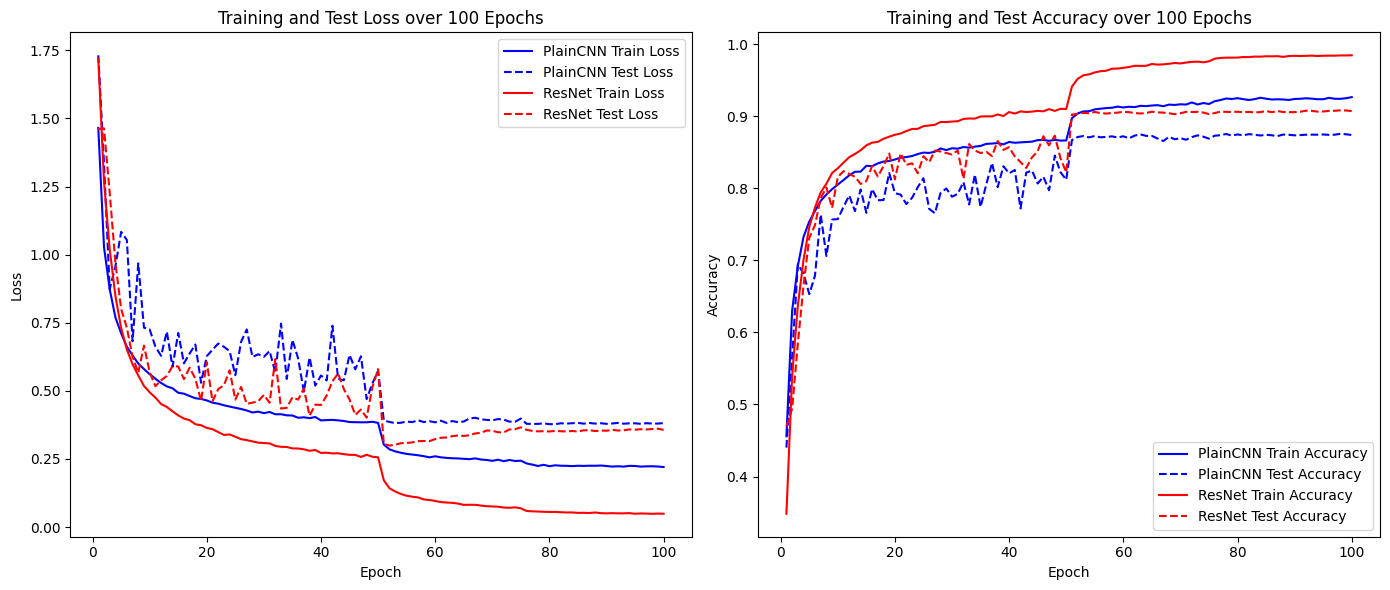

In [8]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses_plain) + 1)  # Should be 100

plt.figure(figsize=(14, 6))

# Plot loss curves
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_plain, 'b-', label='PlainCNN Train Loss')
plt.plot(epochs, test_losses_plain, 'b--', label='PlainCNN Test Loss')
plt.plot(epochs, train_losses_resnet, 'r-', label='ResNet Train Loss')
plt.plot(epochs, test_losses_resnet, 'r--', label='ResNet Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over 100 Epochs')
plt.legend()

# Plot accuracy curves
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs_plain, 'b-', label='PlainCNN Train Accuracy')
plt.plot(epochs, test_accs_plain, 'b--', label='PlainCNN Test Accuracy')
plt.plot(epochs, train_accs_resnet, 'r-', label='ResNet Train Accuracy')
plt.plot(epochs, test_accs_resnet, 'r--', label='ResNet Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy over 100 Epochs')
plt.legend()

plt.tight_layout()
plt.show()


## Final Epoch Accuracy Comparison - Bar Chart

This bar chart compares the final training and testing accuracies of the two models.  
It provides a clear snapshot of the models' performance at the conclusion of training.


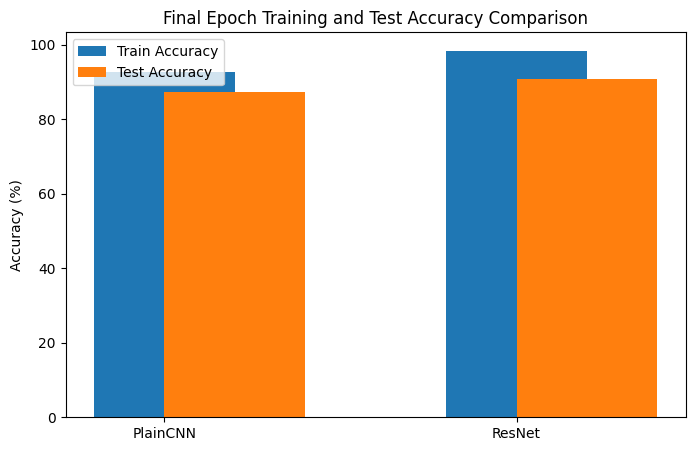

In [9]:
import matplotlib.pyplot as plt

models = ['PlainCNN', 'ResNet']
train_acc_final = [train_accs_plain[-1]*100, train_accs_resnet[-1]*100]
test_acc_final = [test_accs_plain[-1]*100, test_accs_resnet[-1]*100]

x = range(len(models))

plt.figure(figsize=(8,5))
plt.bar(x, train_acc_final, width=0.4, label='Train Accuracy', align='center')
plt.bar(x, test_acc_final, width=0.4, label='Test Accuracy', align='edge')
plt.xticks(x, models)
plt.ylabel('Accuracy (%)')
plt.title('Final Epoch Training and Test Accuracy Comparison')
plt.legend()
plt.show()


## Scatter Plot of Accuracy Across Epochs

This scatter plot shows the training and testing accuracies of both models across all epochs with individual points connected by lines.  
It emphasizes the progression and stability of the models over time.


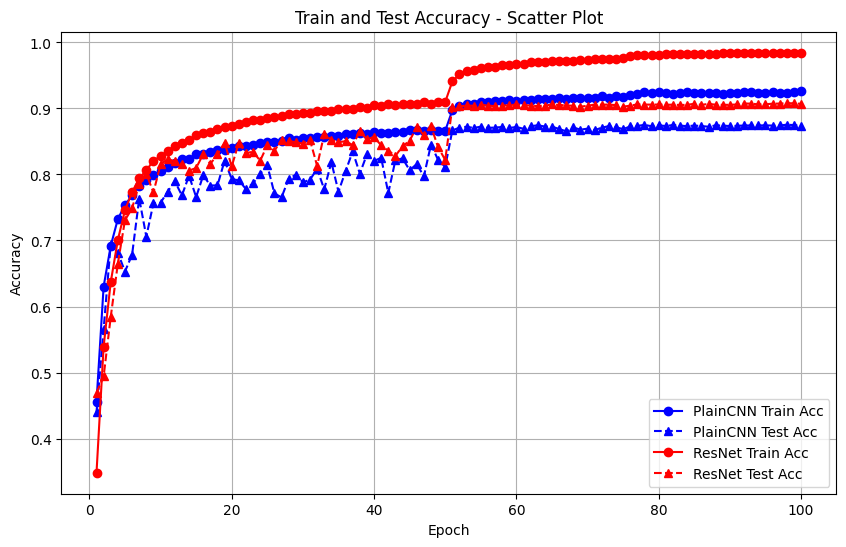

In [10]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_accs_plain) + 1)

plt.figure(figsize=(10,6))

# Scatter plot with lines connecting points
plt.plot(epochs, train_accs_plain, 'bo-', label='PlainCNN Train Acc')
plt.plot(epochs, test_accs_plain, 'b^--', label='PlainCNN Test Acc')
plt.plot(epochs, train_accs_resnet, 'ro-', label='ResNet Train Acc')
plt.plot(epochs, test_accs_resnet, 'r^--', label='ResNet Test Acc')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy - Scatter Plot')
plt.legend()
plt.grid(True)
plt.show()


## Percentage Improvement of ResNet Over PlainCNN

This plot visualizes the percentage difference in accuracy between ResNet and PlainCNN per epoch.  
Positive values indicate ResNet's advantage, portraying how residual connections enhance performance dynamically during training.


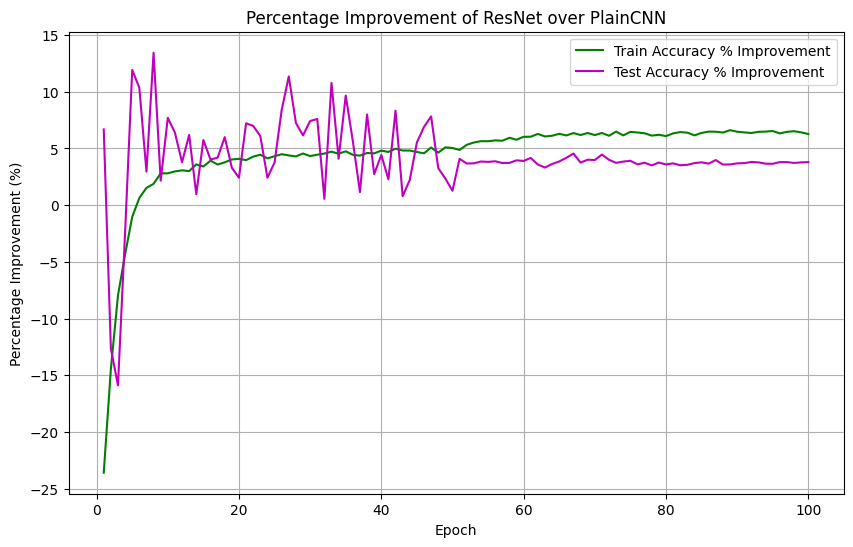

In [11]:
import numpy as np

epochs = range(1, len(train_accs_plain) + 1)

# Calculate percentage improvement of ResNet over PlainCNN for test accuracy
perc_improvement_test = 100 * (np.array(test_accs_resnet) - np.array(test_accs_plain)) / np.array(test_accs_plain)
perc_improvement_train = 100 * (np.array(train_accs_resnet) - np.array(train_accs_plain)) / np.array(train_accs_plain)

plt.figure(figsize=(10,6))
plt.plot(epochs, perc_improvement_train, 'g-', label='Train Accuracy % Improvement')
plt.plot(epochs, perc_improvement_test, 'm-', label='Test Accuracy % Improvement')

plt.xlabel('Epoch')
plt.ylabel('Percentage Improvement (%)')
plt.title('Percentage Improvement of ResNet over PlainCNN')
plt.legend()
plt.grid(True)
plt.show()


## Summary of Comparative Analysis

- ResNet consistently outperforms PlainCNN on both training and testing accuracy, demonstrating the effectiveness of residual connections.
- The learning curves indicate smoother convergence for ResNet and better generalization reflected in the test accuracy.
- Percentage improvement plots quantify the advantage of using a residual architecture.
- Final epoch bar charts summarize the overall performance gains.


In [12]:
import pandas as pd

# Summary stats at final epoch
data = {
    'Model': ['PlainCNN', 'ResNet'],
    'Final Train Accuracy (%)': [train_accs_plain[-1]*100, train_accs_resnet[-1]*100],
    'Final Test Accuracy (%)': [test_accs_plain[-1]*100, test_accs_resnet[-1]*100],
    'Min Train Loss': [min(train_losses_plain), min(train_losses_resnet)],
    'Min Test Loss': [min(test_losses_plain), min(test_losses_resnet)]
}

summary_df = pd.DataFrame(data)
summary_df


,Model,Final Train Accuracy (%),Final Test Accuracy (%),Min Train Loss,Min Test Loss
0,PlainCNN,92.632,87.38,0.220353,0.377795
1,ResNet,98.442,90.70,0.048778,0.299115
